In [140]:
import torch 
import torch.nn as nn
import os 
import sys
# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust if needed

# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

from proteinshake.datasets import ProteinLigandInterfaceDataset, AlphaFoldDataset, GeneOntologyDataset, ProteinFamilyDataset
from src.utils import data_utils as dtu
from torch.utils.data import DataLoader, Dataset, Subset
from src.models.basicVae import LitBasicVae
# from src.models.basicVae_pyt import BasicVae
import numpy as np
from src.dataset_classes.sequenceDataset import *
from sklearn.model_selection import KFold
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
dataset = ProteinFamilyDataset(root='../data').to_point().torch()

In [163]:
import random

indices = list(range(100))  # Example list of indices
subset_size = 10  # Size of the random subset

random_subset = random.sample(indices, subset_size)  # Get random subset
remaining_subset = list(set(indices) - set(random_subset))  # Get remaining indices

print("Random Subset:", random_subset)
print("Remaining Subset:", remaining_subset)

Random Subset: [51, 52, 94, 11, 92, 85, 75, 9, 71, 68]
Remaining Subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 93, 95, 96, 97, 98, 99]


In [164]:
idx_list = range(len(dataset))
subset_size = int(len(dataset)//10)
val_idx = random.sample(idx_list, subset_size)  # Get random subset
train_idx = list(set(idx_list) - set(val_idx))

In [165]:
s = 500
train_subset = SequenceDataset(Subset(dataset, train_idx), s)
val_subset = SequenceDataset(Subset(dataset, val_idx), s)

100%|██████████| 3110/3110 [00:02<00:00, 1122.40it/s]


In [166]:
def ELBO(x, x_hat, x_mu, x_logvar):
    rec_loss = torch.nn.functional.mse_loss(x_hat, x, reduction='sum')
    KL_loss = -0.5 * torch.sum(1 + x_logvar - x_mu.pow(2) - x_logvar.exp())
    return (rec_loss + KL_loss) / x.size(0) 


In [210]:
latent_dim = 64
epochs = 100
lr = 0.001
batch_size = 256
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset,batch_size=batch_size, shuffle=False)
x_dim = train_subset[0].shape[0]
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [212]:

model = LitBasicVae(latent_dim=latent_dim, seq_len= s, amino_acids = 21, optimizer=torch.optim.Adam, optimizer_param={'lr':0.001}, beta = 1)
model

LitBasicVae(
  (relu): ReLU()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0.4, inplace=False)
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (fc3_enc_mean): Linear(in_features=512, out_features=64, bias=True)
  (fc3_enc_logvar): Linear(in_features=512, out_features=64, bias=True)
  (fc1_dec): Linear(in_features=64, out_features=512, bias=True)
  (fc3_dec): Linear(in_features=512, out_features=10500, bias=True)
)

In [213]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
optimizer = torch.optim.Adam
optimizer_param = {'lr':0.001}
trainer = pl.Trainer(max_epochs=epochs,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"))
# model = LitBasicVae(latent_dim, x_dim, optimizer, optimizer_param,)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [214]:
trainer.fit(model, train_dataloader, val_dataloader)

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name           | Type    | Params | Mode 
---------------------------------------------------
0 | relu           | ReLU    | 0      | train
1 | soft           | Softmax | 0      | train
2 | dropout_layer  | Dropout | 0      | train
3 | fc1_enc        | Linear  | 5.4 M  | train
4 | fc3_enc_mean   | Linear  | 32.8 K | train
5 | fc3_enc_logvar | Linear  | 32.8 K | train
6 | fc1_dec        | Linear  | 33.3 K | train
7 | fc3_dec        | Linear  | 5.4 M  | train
---------------------------------------------------
10.9 M    Trainable params
0         Non-trainable params
10.9 M    Total params
43.448    Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
for batch in train_dataloader:
    model

# Model Visualisation

In [171]:
dataset = ProteinFamilyDataset(root = '../data').to_point().torch()

In [156]:
# Load the trained model from checkpoint
checkpoint_path = "logs/lightning_logs/version_0/checkpoints/epoch=99-step=1300.ckpt"
model = LitBasicVae.load_from_checkpoint(checkpoint_path)

# Put model in evaluation mode
model.eval()


LitBasicVae(
  (relu): ReLU()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0.4, inplace=False)
  (maxpooling): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_1): Conv1d(21, 128, kernel_size=(5,), stride=(1,), padding=same)
  (conv_2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
  (fc1_enc): Linear(in_features=32000, out_features=512, bias=True)
  (fc3_enc_mean): Linear(in_features=512, out_features=16, bias=True)
  (fc3_enc_logvar): Linear(in_features=512, out_features=16, bias=True)
  (fc1_dec): Linear(in_features=16, out_features=512, bias=True)
  (fc3_dec): Linear(in_features=512, out_features=10500, bias=True)
)

In [216]:
seq_dataset = SequenceDataset(dataset, 500, return_proteins=True)
seq_dataloader = DataLoader(seq_dataset, batch_size= 256, shuffle = False)

100%|██████████| 31109/31109 [00:13<00:00, 2247.11it/s]


In [218]:
lengths = [k[0].shape[0] for k in seq_dataset.org_protein_data]

In [219]:
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

LitBasicVae(
  (relu): ReLU()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0.4, inplace=False)
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (fc3_enc_mean): Linear(in_features=512, out_features=64, bias=True)
  (fc3_enc_logvar): Linear(in_features=512, out_features=64, bias=True)
  (fc1_dec): Linear(in_features=64, out_features=512, bias=True)
  (fc3_dec): Linear(in_features=512, out_features=10500, bias=True)
)

In [220]:
labels = []
latent_coord = []
model.eval()
total_samples = []
for batch_i, batch in enumerate(seq_dataloader):
    # print(batch.shape)
    # labels.append(batch[1].to('cpu').numpy())
    rep_z, x_mu, x_logvar, x_rec, logit = model(batch)
    total_samples.append(x_mu.shape[0])
    latent_coord.append(x_mu.detach().numpy())
# labels = np.concatenate(labels)``
latent_coord = np.concatenate(latent_coord, axis = 0)

In [221]:
U, S, V = torch.pca_lowrank(torch.tensor(latent_coord), q=None, center=True, niter=2)

In [222]:
projected_data = torch.matmul(torch.tensor(latent_coord), V[:, :2]) 

In [223]:
latent_coord.shape

(28751, 64)

In [224]:
projected_data.shape

torch.Size([28751, 2])

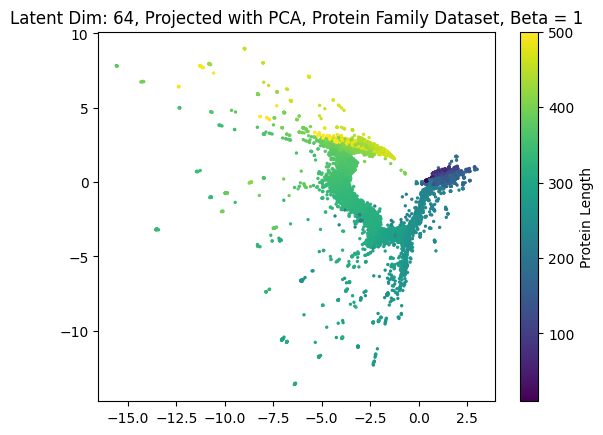

In [228]:
import matplotlib.pyplot as plt
plt.scatter(projected_data[:, 0], projected_data[:, 1], s = 2, c=lengths, cmap='viridis')
plt.colorbar(label = 'Protein Length')
plt.title('Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1')
plt.savefig("exp_1_latent_Pfam.png")